# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
# Spark libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand, approx_count_distinct,count, when
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.functions import sum as fsum

from pyspark.sql.types import IntegerType, FloatType, StringType

# Spark ML libraries
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Statistical testing libraries
from scipy.stats import chi2_contingency, ttest_ind

# python data science libraries
import re
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
!python --version

Python 3.6.3


In [3]:
!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 2.4.3
      /_/
                        
Using Scala version 2.11.12, OpenJDK 64-Bit Server VM, 1.8.0_265
Branch 
Compiled by user  on 2019-05-01T05:08:38Z
Revision 
Url 
Type --help for more information.


In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("sparkify_session") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [6]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Check out catogory variables in the data
df.select('auth').dropDuplicates().sort('auth').show(), df.select('level').dropDuplicates().sort('level').show(), df.select('location').dropDuplicates().sort('location').show(),
df.select('method').dropDuplicates().sort('method').show(), df.select('page').dropDuplicates().sort('page').show(), 
df.select('status').dropDuplicates().sort('status').show(), df.select('gender').dropDuplicates().show()

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+--------------------+
|            location|
+--------------------+
|                null|
|          Albany, OR|
|Albany-Schenectad...|
|      Alexandria, LA|
|Allentown-Bethleh...|
|       Anchorage, AK|
|Atlanta-Sandy Spr...|
|Atlantic City-Ham...|
|Austin-Round Rock...|
|     Bakersfield, CA|
|Baltimore-Columbi...|
|        Billings, MT|
|Birmingham-Hoover...|
|Boston-Cambridge-...|
|         Boulder, CO|
|         Bozeman, MT|
|Bridgeport-Stamfo...|
|Buffalo-Cheektowa...|
|Charlotte-Concord...|
|Chicago-Napervill...|
+--------------------+
only showing top 20 rows

+------+
|method|
+------+
|   GET|
|   PUT|
+------+

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|     

(None, None)

In [8]:
# Numerical values
df.describe('itemInSession').show(), df.describe('length').show() ,df.select('userId').dropDuplicates().sort('userId').show(), df.select('userAgent').dropDuplicates().sort('userAgent').show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201140994|
|    min|                 0|
|    max|              1321|
+-------+------------------+

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows

+--------------------+
|           userAgent|
+--------------------+
|                null|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0

(None, None, None, None)

In [9]:
# There is empty string for userId and null values for userAgent, gender and location. First excluded the userId empty string.
df.filter(df['userId']=='').count()
df_clean = df.filter(df['userId'] != '')

In [10]:
df_clean.describe('itemInSession').show(), df_clean.describe('length').show() ,df_clean.select('userId').dropDuplicates().sort('userId').show(), df_clean.select('userAgent').dropDuplicates().sort('userAgent').show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|  129.851729399489|
|    min|                 0|
|    max|              1321|
+-------+------------------+

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
|100018|
+------+
only showing top 20 rows

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0

(None, None, None, None)

In [11]:
# timestamp to datetime format
ts_todate = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d %H:%M:%S'))

df_clean = df_clean.withColumn('datetime', ts_todate(df_clean.ts))

In [12]:
df_clean.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', datetime='2018-10-01 00:01:57')]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
# Explore some of the variables using sql
df_clean.createOrReplaceTempView('Sparkify_table')

In [14]:
# The total number of entries
spark.sql('''

        SELECT count(*)
        FROM Sparkify_table

        ''').show()

+--------+
|count(1)|
+--------+
|  278154|
+--------+



In [15]:
# The number of unique users
spark.sql('''
          SELECT count(DISTINCT userId) as Unique_Users
          FROM Sparkify_table
            
            ''').show()

+------------+
|Unique_Users|
+------------+
|         225|
+------------+



In [16]:
# The number of users canceled
spark.sql('''
        SELECT auth, count(DISTINCT userID) as count_users
        FROM Sparkify_table
        GROUP BY auth
        ORDER BY count_users DESC
        ''').show()

+---------+-----------+
|     auth|count_users|
+---------+-----------+
|Logged In|        225|
|Cancelled|         52|
+---------+-----------+



In [17]:
# Number of users by gender
spark.sql('''
        SELECT gender, count(DISTINCT userID) as count_users
        FROM Sparkify_table
        GROUP BY gender
        ORDER BY count_users DESC
        ''').show()

+------+-----------+
|gender|count_users|
+------+-----------+
|     M|        121|
|     F|        104|
+------+-----------+



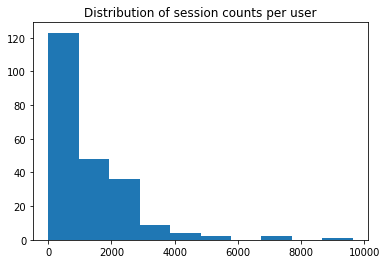

In [18]:
# Plot the distribution of session counts
sessions_perId = spark.sql('''
        SELECT userId, count(sessionId) as count_sessions
        FROM Sparkify_table
        GROUP BY userId
        ORDER BY count_sessions DESC
        ''')
plt.hist(x = 'count_sessions',data = sessions_perId.toPandas());
plt.title("Distribution of session counts per user");

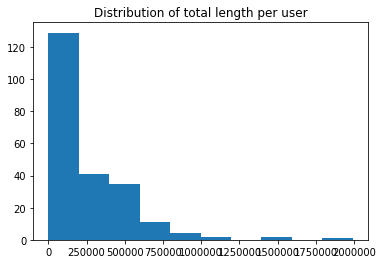

In [19]:
# The total use length per user
total_length = spark.sql('''
        SELECT userId, sum(length) as total_length
        FROM Sparkify_table
        GROUP BY userId
        ORDER BY total_length DESC
        ''').toPandas()
plt.hist(x = 'total_length', data = total_length);
plt.title("Distribution of total length per user");

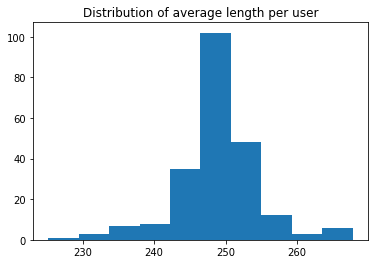

In [20]:
# and avarage use length per session per user
average_length = spark.sql('''
        SELECT userId, mean(length) as mean_length
        FROM Sparkify_table
        GROUP BY userId
        ORDER BY mean_length DESC
        ''').toPandas()
plt.hist(x = 'mean_length', data = average_length);
plt.title("Distribution of average length per user");

In [21]:
# Locations
locations = spark.sql('''
        SELECT location, count(userId) as count_user
        FROM Sparkify_table
        GROUP BY location
        ORDER BY count_user DESC
        ''').toPandas()

In [22]:
locations.head()

,location,count_user
0,"Los Angeles-Long Beach-Anaheim, CA",30131
1,"New York-Newark-Jersey City, NY-NJ-PA",23684
2,"Boston-Cambridge-Newton, MA-NH",13873
3,"Houston-The Woodlands-Sugar Land, TX",9499
4,"Charlotte-Concord-Gastonia, NC-SC",7780


In [23]:
# Divide location data to cities and states
locations = locations.join(locations['location'].str.split(',', expand = True).rename(columns = {0: 'city', 1: 'state'})).drop('location', axis = 1)
locations.head()

,count_user,city,state
0,30131,Los Angeles-Long Beach-Anaheim,CA
1,23684,New York-Newark-Jersey City,NY-NJ-PA
2,13873,Boston-Cambridge-Newton,MA-NH
3,9499,Houston-The Woodlands-Sugar Land,TX
4,7780,Charlotte-Concord-Gastonia,NC-SC


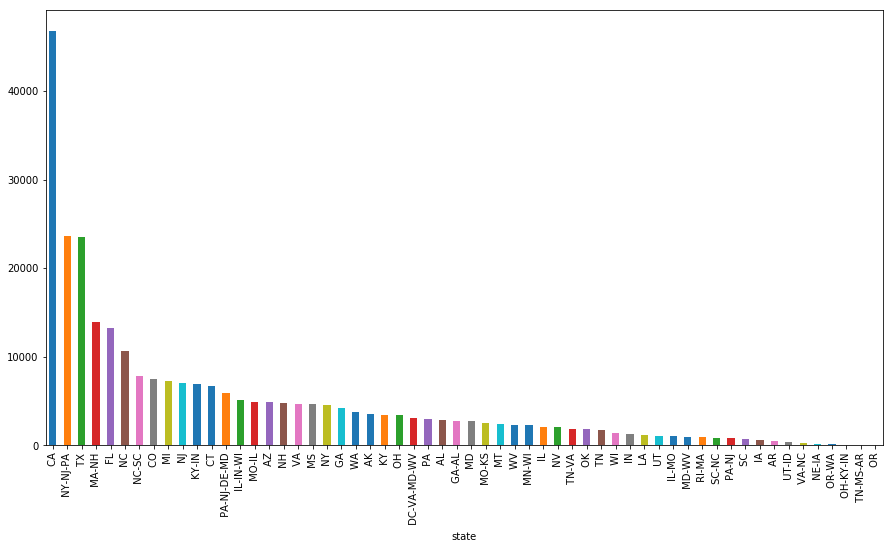

In [24]:
location_state = locations.groupby('state')['count_user'].sum().sort_values(ascending=False)
location_state.plot(kind='bar', figsize=(15,8));

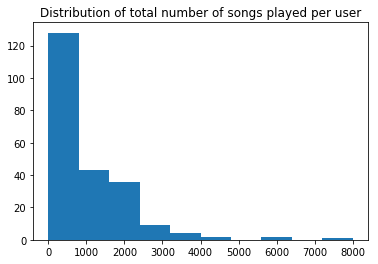

In [25]:
# total number of songs played per user
n_songs = spark.sql('''
        SELECT userId, count(song) as count_songs
        FROM Sparkify_table
        GROUP BY userId
        ORDER BY count_songs DESC
        ''').toPandas()
plt.hist(x = 'count_songs', data = n_songs);
plt.title("Distribution of total number of songs played per user");

In [26]:
# number of songs played per user per session
n_songs_session = spark.sql('''
        SELECT userId, sessionId, count(song) as count_songs
        FROM Sparkify_table
        GROUP BY userId, sessionId
        ORDER BY count_songs DESC
        ''').toPandas()


In [27]:
n_songs_session.head()

,userId,sessionId,count_songs
0,91,1840,1093
1,115,316,900
2,101,635,708
3,120,731,648
4,25,827,593


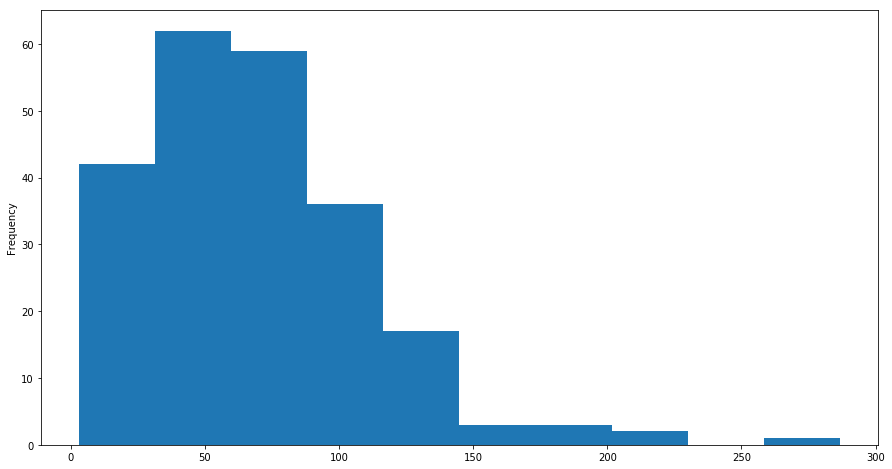

In [28]:
# average songs played per session each user
n_songs_session.groupby('userId')['count_songs'].mean().plot(kind='hist', figsize=(15,8));

In [29]:
# Explore time and date patterns
time_data = spark.sql('''
                    SELECT datetime, userId
                    FROM Sparkify_table
                        ''').toPandas()
time_data.head()


,datetime,userId
0,2018-10-01 00:01:57,30
1,2018-10-01 00:03:00,9
2,2018-10-01 00:06:34,30
3,2018-10-01 00:06:56,9
4,2018-10-01 00:11:16,30


In [30]:
time_data['datetime'] = pd.to_datetime(time_data['datetime'], format='%Y-%m-%d %H:%M:%S')

In [31]:
# datetime to sub-variables
month_recode = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
time_data['month'] = time_data['datetime'].dt.month.map(month_recode)
weekday_recode = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
time_data['weekday'] = time_data['datetime'].dt.weekday.map(weekday_recode)
time_data['day'] = time_data['datetime'].dt.day
time_data['hour'] = time_data['datetime'].dt.hour
time_data.head()

,datetime,userId,month,weekday,day,hour
0,2018-10-01 00:01:57,30,October,Monday,1,0
1,2018-10-01 00:03:00,9,October,Monday,1,0
2,2018-10-01 00:06:34,30,October,Monday,1,0
3,2018-10-01 00:06:56,9,October,Monday,1,0
4,2018-10-01 00:11:16,30,October,Monday,1,0


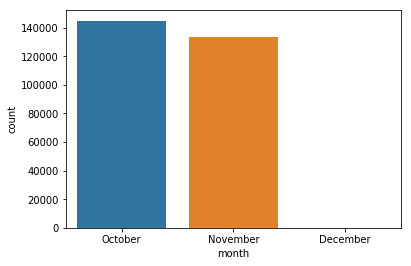

In [32]:
sns.countplot(x = 'month', data = time_data);

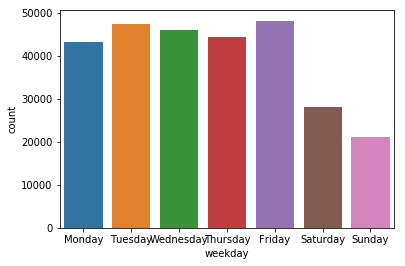

In [33]:
sns.countplot(x = 'weekday', data = time_data);

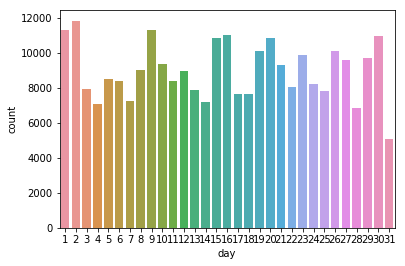

In [34]:
sns.countplot(x = 'day', data = time_data);

In [35]:
# UserAgent
userAgent = spark.sql('''
    SELECT userAgent,count(DISTINCT userId) as n_users
    FROM Sparkify_table
    GROUP BY userAgent
    ''').toPandas()

In [36]:
userAgent.head()

,userAgent,n_users
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5...",1
1,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....",4
2,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0)...,1
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",16
4,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",2


In [37]:
pd.set_option('display.max_colwidth', -1)
userAgent.head()

,userAgent,n_users
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",1
1,"""Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36""",4
2,Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0,1
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36""",16
4,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36""",2


In [38]:
import re
text = userAgent.iloc[0,0]
text
re.search('\(([^)]+)', text).group(1).split(';')[0]

'Macintosh'

In [39]:
def get_platform(text):
    platform = re.search('\(([^)]+)', text).group(1).split(';')[0]
    if 'Windows NT' in platform:
        platform = 'Windows'
    return platform



In [40]:
userAgent['platform'] = userAgent['userAgent'].apply(get_platform)

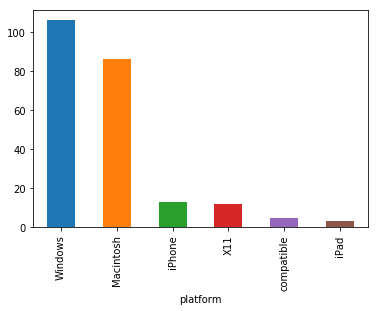

In [41]:
userAgent.groupby('platform').sum()['n_users'].sort_values(ascending = False).plot(kind = 'bar')

In [42]:
#Define churn
flag_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_clean_churn = df_clean.withColumn("flag_churn", flag_churn("page"))
df_clean_churn = df_clean_churn.withColumn('churn', fmax('flag_churn').over(Window.partitionBy('UserId')))

In [43]:
df_clean_churn.show(1)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|           datetime|flag_churn|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|2018-1

In [44]:
df_clean_churn['location']

Column<b'location'>

In [45]:
# Explore catagorical features: gender, State from Location, user platform from userAgent
# define functions to get Location States and user platform
get_state = udf(lambda x: x.split(', ')[1])
df_clean_churn = df_clean_churn.withColumn('location_state', get_state("location"))
df_clean_churn.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', datetime='2018-10-08 12:58:54', flag_churn=0, churn=0, location_state='CT')]

In [46]:
get_platform_udf = udf(lambda x: get_platform(x))
df_clean_churn = df_clean_churn.withColumn('platform', get_platform_udf("userAgent"))
df_clean_churn.take(2)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', datetime='2018-10-08 12:58:54', flag_churn=0, churn=0, location_state='CT', platform='iPhone'),
 Row(artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender='F', itemInSession=1, lastName='Carpenter', length=196.54485, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=200, ts=1539003736000, userAgent='"Mozilla/5.0 (iPhone; C

In [47]:
# summarize catagorical variables and check if there exist differences between users churned or not

def summarize_churn_catagorical(variable):
    '''
    INPUT: variable --> the variable column name for which we want to summarize
    
    DESCRIPTION: This function gives a table showing the subgroup count in users churned or not for the variable,
    and calculate the p-value based on chi-square contingency test.
    
    '''
    
    summary = df_clean_churn.dropDuplicates(["userId", variable]).groupby(["churn", variable]).count().sort("churn")
    summary.show()
    subdata = df_clean_churn.dropDuplicates(["userId", variable])[variable,'churn'].toPandas()

    table = pd.crosstab(index = subdata['churn'], columns = subdata[variable])
    g, p, dof, expctd = chi2_contingency(table)
    print('p-value=',p)


In [48]:
summarize_churn_catagorical('gender')

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   84|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+

p-value= 0.262077193198


In [49]:
summarize_churn_catagorical('location_state')

+-----+--------------+-----+
|churn|location_state|count|
+-----+--------------+-----+
|    0|            WA|    2|
|    0|      NY-NJ-PA|   10|
|    0|            TX|   13|
|    0|            IN|    2|
|    0|            MD|    1|
|    0|         MO-KS|    1|
|    0|            NC|    5|
|    0|            FL|   11|
|    0|            TN|    1|
|    0|            WV|    1|
|    0|         NC-SC|    6|
|    0|            MI|    2|
|    0|         MN-WI|    3|
|    0|            OK|    1|
|    0|            NH|    2|
|    0|            MT|    1|
|    0|      OH-KY-IN|    2|
|    0|            MS|    1|
|    0|            SC|    1|
|    0|            IA|    1|
+-----+--------------+-----+
only showing top 20 rows

p-value= 0.419185134179


In [50]:
summarize_churn_catagorical('platform')

+-----+----------+-----+
|churn|  platform|count|
+-----+----------+-----+
|    0|compatible|    5|
|    0|       X11|    7|
|    0|      iPad|    3|
|    0|    iPhone|    9|
|    0|   Windows|   82|
|    0| Macintosh|   67|
|    1| Macintosh|   19|
|    1|   Windows|   24|
|    1|    iPhone|    4|
|    1|       X11|    5|
+-----+----------+-----+

p-value= 0.389380119805


In [51]:
# Catagorical variable into numerical: pages (percentage of each page), datetime
# page
page_data = df_clean_churn.select(['page', 'churn']).groupBy(['page', 'churn']).count().toPandas()
page_data['percentage'] = 100 * page_data['count'] / page_data.groupby('churn')['count'].transform('sum')
page_data

,page,churn,count,percentage
0,Thumbs Up,0,10692,4.583137
1,Upgrade,0,387,0.165888
2,Logout,0,2673,1.145784
3,Upgrade,1,112,0.249643
4,Add Friend,1,636,1.417618
5,Error,1,32,0.071327
6,Home,1,1672,3.726819
7,NextSong,0,191714,82.178405
8,Submit Upgrade,0,127,0.054439
9,Help,0,1215,0.520811


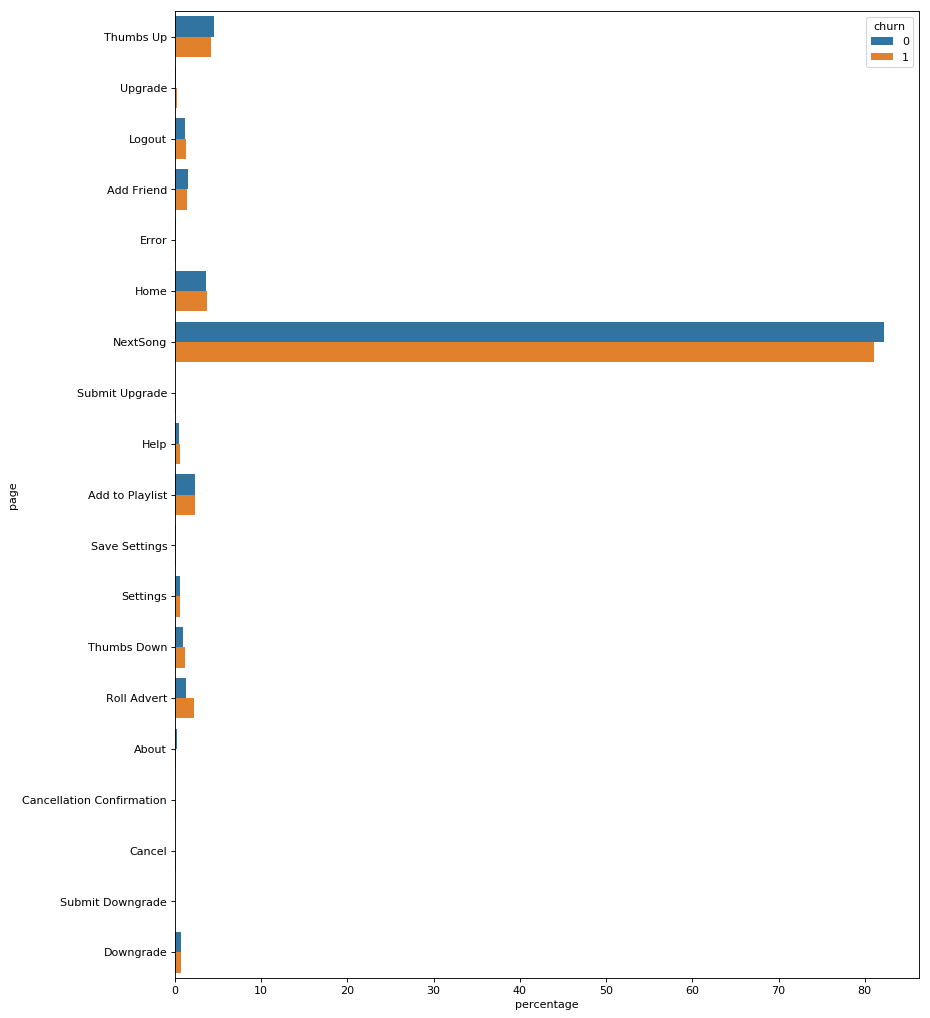

In [52]:
plt.figure(figsize=(12, 16), dpi=80)
sns.barplot(y = 'page', x = 'percentage', hue = 'churn', data = page_data);

In [53]:
# percentage looks similar, only a bit more thumbs down and roll advert

In [54]:
# summarize datetime, get month, weekday, day and hour from timestamp.
get_weekday = udf(lambda x: str(datetime.datetime.fromtimestamp(x/1000.0).strftime('%w')))
get_day = udf(lambda x: str(datetime.datetime.fromtimestamp(x/1000.0).day))
get_hour = udf(lambda x: str(datetime.datetime.fromtimestamp(x/1000.0).hour))

df_clean_churn = df_clean_churn.withColumn("weekday", get_weekday("ts"))
df_clean_churn = df_clean_churn.withColumn("day", get_day("ts"))
df_clean_churn = df_clean_churn.withColumn("hour", get_hour("ts"))
df_clean_churn.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', datetime='2018-10-08 12:58:54', flag_churn=0, churn=0, location_state='CT', platform='iPhone', weekday='1', day='8', hour='12')]

In [55]:
def summarize_percentage_catagorial(col):
    '''
    INPUT: variable --> a catogorical variable: this catagorial variable changes by session
    
    DESCRIPTION: This function plot the percentage of the subgroups for the catagorial variable between users churned or not.
    
    '''
    col_data = df_clean_churn.select([col, 'churn']).groupBy([col, 'churn']).count().toPandas()
    col_data['percentage'] = 100 * col_data['count'] / col_data.groupby('churn')['count'].transform('sum')
    plt.figure(figsize=(16, 6), dpi=80)
    sns.barplot(x = col, y = 'percentage', hue = 'churn', data = col_data, order = list(map(lambda x: str(x), range(len(col_data[col].unique())+1))));


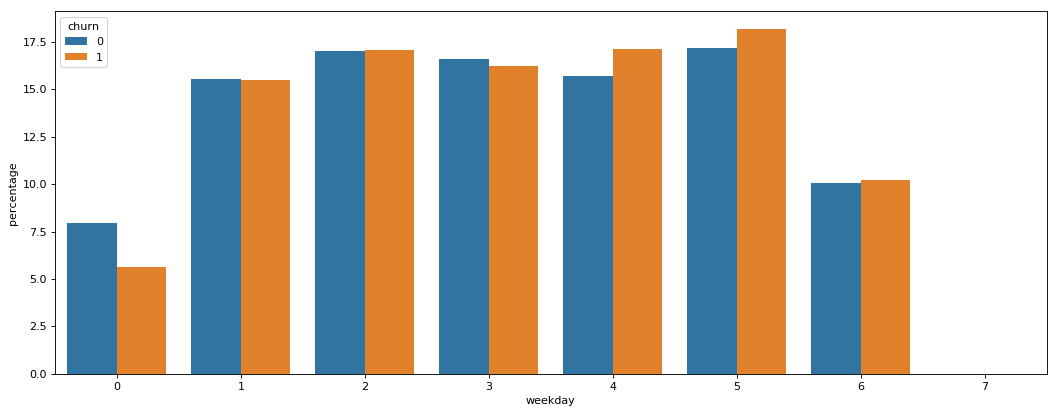

In [56]:
summarize_percentage_catagorial("weekday")

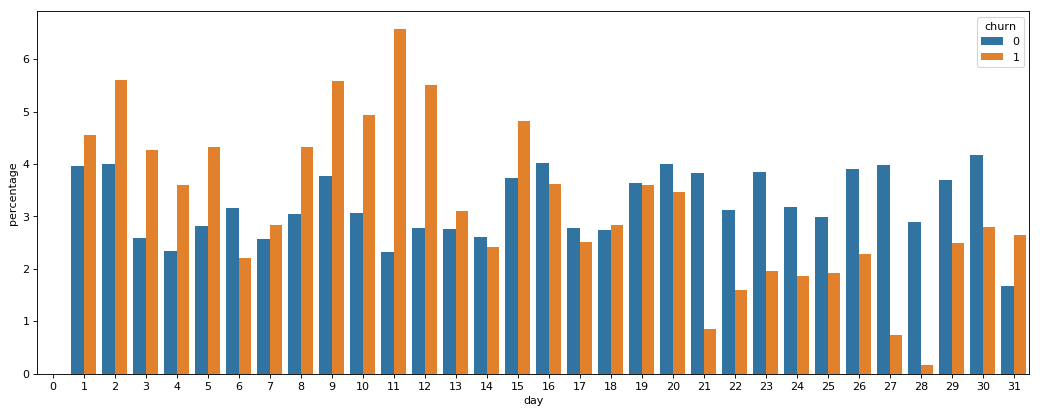

In [57]:
summarize_percentage_catagorial("day")

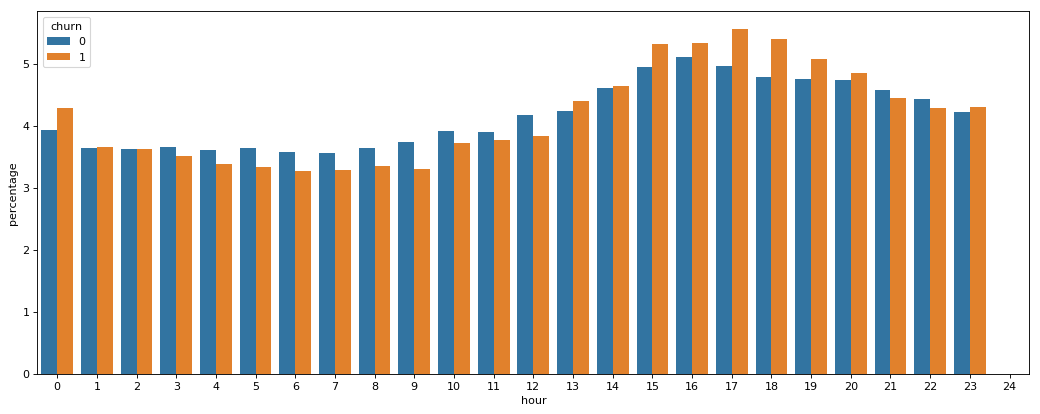

In [58]:
summarize_percentage_catagorial("hour")

In [59]:
# Weekday look similar, but day in the month seems to have very different patterns between users who churned and who not. 
# Churned users are more active in the first half of the month.
# For hour of the day, users who churned seems to use it more during 15-20 hours, and less during 3-12 hours.
# New variables [percentage of use in the first half of the month] and [percentage of use in the first half of the day] can
# be used to train the model.

In [60]:
# Explore numerical features: average number of items in each session, total length/average length per session, number of unique songs listened, the number of artists listened to

agg_data = df_clean_churn.select(['userId', 'churn','itemInSession','length', 'song', 'artist']).groupby(['userId']) \
        .agg(fmax('churn').alias('churn'),
            avg('itemInSession').alias('average_itemInSession'),
            avg('length').alias('average_length'),
            fsum('length').alias('total_length'),
            approx_count_distinct('song').alias('num_unique_songs'),
            approx_count_distinct('artist').alias('num_unique_artists')).toPandas()

In [61]:
agg_data

,userId,churn,average_itemInSession,average_length,total_length,num_unique_songs,num_unique_artists
0,100010,0,35.895013,243.421445,6.694090e+04,274,249
1,200002,0,60.578059,242.916992,9.400888e+04,377,330
2,125,1,5.000000,261.139138,2.089113e+03,8,8
3,124,0,165.099275,248.176537,1.012312e+06,3279,2197
4,51,1,200.603490,247.880551,5.232758e+05,1897,1392
5,7,0,27.825871,253.560581,3.803409e+04,150,137
6,15,0,116.011853,249.377015,4.773076e+05,1765,1311
7,54,1,113.986616,250.385399,7.113449e+05,2464,1731
8,155,0,120.156687,242.413771,1.987793e+05,751,615
9,100014,1,34.538710,263.437635,6.770347e+04,264,242


In [62]:
def summarize_numerial_variable(col):
    '''
    INPUT: col --> column name of a numerical variable in the dataset for which
    we want to summarize.
    
    DESCRIPTION: This function prints the average value of this numerical variable 
    in users who churned and who did not,
    and gives the p-value of the t-test comparison between the two groups.
    '''
    print(agg_data.groupby('churn')[col].mean())
    print(ttest_ind(agg_data.loc[agg_data['churn'] == 0, col],agg_data.loc[agg_data['churn'] == 1, col]))

In [63]:
for column in agg_data.columns[2:]:
    summarize_numerial_variable(column)

churn
0    89.134634
1    72.395912
Name: average_itemInSession, dtype: float64
Ttest_indResult(statistic=1.8312627354860118, pvalue=0.068395543863040587)
churn
0    249.141254
1    248.307865
Name: average_length, dtype: float64
Ttest_indResult(statistic=0.88644817737172454, pvalue=0.37633101851790407)
churn
0    276166.937468
1    174014.268551
Name: total_length, dtype: float64
Ttest_indResult(statistic=2.3694782412455946, pvalue=0.018666181281982965)
churn
0    972.554913
1    633.346154
Name: num_unique_songs, dtype: float64
Ttest_indResult(statistic=2.4279264894525472, pvalue=0.015978318856346759)
churn
0    752.075145
1    526.192308
Name: num_unique_artists, dtype: float64
Ttest_indResult(statistic=2.374594379028562, pvalue=0.018415942494719544)


In [64]:
# We can see that there is difference in total_length, num_unique_songs and num_unique_artists between 
# users who churned and users who have not churned
# these three variables may be correlated. they represent the time that the user has been using the app.
# average_itemInSession is nearly significantly different between the two groups:
# the ones not churned using more items per session

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [65]:
# We will use the following features to train the model:
# 1. catagorical variables: gender, (location_state), platform
# 2. having visited page thumbs down or roll advert or not 
# 3. percentage of use in the first half of the month
# 4. percentage of use in the first half of the day
# 5. numerical variables: average_itemInSession, average_length, total_length, num_unique_songs, num_unique_artists

In [4]:
# feature engineering functions
# clean data
def clean_data(df):
    '''
    INPUT: df --> the raw sparkify data.
    OUTPUT: df_clean --> a new dataframe that removes empty strings in userId (users who logged out).
    
    DESCRIPTION: This function takes in the raw sparkify dataframe and cleans it.
    
    '''
    # removes unidentifiable userIds
    df_clean = df.filter(df['userId'] != '')
    return df_clean

# get new variables to get features

# User defined functions
def get_platform(text):
    platform = re.search('\(([^)]+)', text).group(1).split(';')[0]
    if 'Windows NT' in platform:
        platform = 'Windows'
    return platform


flag_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
get_state = udf(lambda x: x.split(', ')[1])
get_platform_udf = udf(lambda x: get_platform(x))
get_weekday = udf(lambda x: str(datetime.datetime.fromtimestamp(x/1000.0).strftime('%w')))
get_day = udf(lambda x: str(datetime.datetime.fromtimestamp(x/1000.0).day))
get_hour = udf(lambda x: str(datetime.datetime.fromtimestamp(x/1000.0).hour))


def get_variables(df_clean):
    '''
    INPUT: df_clean --> dataframe without entries of logged out users.
    OUTPUT: df_clean_churn --> a new dataframe that adds additional variables for further analyses.
    
    DESCRIPTION: This function adds the following variables to the data:
    churn --> user churn status extracted from 'cancellation confirmation' from ['page']
    platform --> platform extracted from ['userAgent'].
    location_state --> the State of the user location extracted from ['location']
    day --> day of the entry extracted from ['ts']
    hour --> hour of the entry extracted from ['ts']
    roll_advert --> whether the user has visited page 'Roll Advert'
    thumbs_down --> whether the user has visited page 'Thumbs Down'
    
    '''
        
    # get churn variable
    df_clean_churn = df_clean.withColumn("flag_churn", flag_churn("page"))
    df_clean_churn = df_clean_churn.withColumn('churn', fmax('flag_churn').over(Window.partitionBy('UserId')))
    
    # get platfrom variable
    df_clean_churn = df_clean_churn.withColumn('platform', get_platform_udf("userAgent"))
    
    # get location the state
    df_clean_churn = df_clean_churn.withColumn('location_state', get_state("location"))
    
    # get weekday, day in a month, and hour in a day


    df_clean_churn = df_clean_churn.withColumn("day", get_day("ts"))
    df_clean_churn = df_clean_churn.withColumn("hour", get_hour("ts"))
    roll_advert = df_clean_churn.where(df_clean_churn.page == 'Roll Advert').select('userId').distinct()
    roll_advert_list = list(roll_advert.select('userId').toPandas()['userId'])
    if_roll_advert = udf(lambda x: 1 if (x in roll_advert_list) else 0)

    df_clean_churn = df_clean_churn.withColumn('roll_advert', if_roll_advert('userId'))
    
    thumbs_down = df_clean_churn.where(df_clean_churn.page == 'Thumbs Down').select('userId').distinct()
    thumbs_down_list = list(thumbs_down.select('userId').toPandas()['userId'])
    if_thumbs_down = udf(lambda x: 1 if (x in thumbs_down_list) else 0)
    df_clean_churn = df_clean_churn.withColumn('thumbs_down', if_thumbs_down('userId'))
    
    return df_clean_churn

# encode catagorical variables (gender, location_state, platform)


def get_percentage_use_first15days(df_clean_churn):
    '''
    INPUT: df_clean_churn --> the dataframe with additional variables.
    OUTPUT: first15days --> a dataframe containing user information of their percentage 
    use in the first 15 days of month.
    
    DESCRIPTION: This function calculates the percentage of use in the first 15 days of 
    month for each user.
    
    '''
    total_count = df_clean_churn.select(['userId']).groupby(["userId"]).count()
    count_first15days = df_clean_churn.filter(df_clean_churn.day < 15).select(['userId']).groupby(["userId"]).count()
    first15days = (total_count.alias("total").join(count_first15days.alias("count_first15days"), ["userId"]).\
                              select(col("userId"), (col("count_first15days.count") / col("total.count")).\
                                     alias("percentage_use_first15days")))
    return first15days
    
    
def get_percentage_use_after12h(df_clean_churn):
    '''
    INPUT: df_clean_churn --> the dataframe with additional variables.
    OUTPUT: after12h --> a dataframe containing user information of their percentage 
    use after 12h in a day.
    
    DESCRIPTION: This function calculates the percentage of use after 12h in a day for 
    each user.
    
    '''  
    total_count = df_clean_churn.select(['userId']).groupby(["userId"]).count()
    count_first15days = df_clean_churn.filter(df_clean_churn.hour >12 ).select(['userId']).groupby(["userId"]).count()
    after12h = (total_count.alias("total").join(count_first15days.alias("count_after12h"), ["userId"]).\
                              select(col("userId"), (col("count_after12h.count") / col("total.count")).\
                                     alias("percentage_use_after12h")))
    return after12h
  
    
def catogorical_encoding(df_clean_churn):
    '''
    INPUT: df_clean_churn --> the dataframe with additional variables.
    OUTPUT: cata_data --> a dataframe containing catagorical variables.
    
    DESCRIPTION: This function takes out selected catagorical variables from the dataframe.
    
    '''  
    cata_data = df_clean_churn.select(['userId', 'roll_advert', 'thumbs_down', 'gender', 'location_state', 'platform']).dropDuplicates()
    return cata_data


def numerical_encoding(df_clean_churn):
    '''
    INPUT: df_clean_churn --> the dataframe with additional variables.
    OUTPUT: agg_data --> a dataframe containing numerical variables.
    
    DESCRIPTION: This function takes out selected numerical variables from the dataframe.
    
    '''  
    agg_data = df_clean_churn.select(['userId', 'churn','itemInSession','length']).groupby(['userId']) \
        .agg(fmax('churn').alias('label'),
            avg('itemInSession').alias('average_itemInSession'),
            avg('length').alias('average_length'),
            fsum('length').alias('total_length'))
    agg_song_artist = df_clean_churn.filter(df_clean_churn.page == 'NextSong').select(['userId','song', 'artist']) \
            .groupby(['userId']) \
            .agg(approx_count_distinct('song').alias('num_unique_songs'),
               approx_count_distinct('artist').alias('num_unique_artists'))
    agg_data = agg_data.join(agg_song_artist, 'userId', "inner")
    return agg_data


def get_features(df_clean_churn):
    '''
    INPUT: df_clean_churn --> the dataframe with additional variables.
    OUTPUT: data --> a dataframe containing variables that will be used for churn prediction.
    
    DESCRIPTION: This function get variables that will be used for churn prediction and combine 
    them as one dataframe.
    
    '''  
    use_first15_days = get_percentage_use_first15days(df_clean_churn)
    user_after12h = get_percentage_use_after12h(df_clean_churn)
    catagorical_variables = catogorical_encoding(df_clean_churn)
    numerical_variables = numerical_encoding(df_clean_churn)
    data = numerical_variables.join(use_first15_days, 'userId', "inner")\
            .join(user_after12h, 'userId', "inner") \
            .join(catagorical_variables, 'userId', "inner") 
    return data


In [5]:
df_clean = clean_data(df)
df_clean_churn = get_variables(df_clean)
model_data = get_features(df_clean_churn)
model_data.show(1)

+------+-----+---------------------+----------------+-----------------+----------------+------------------+--------------------------+-----------------------+-----------+-----------+------+--------------+--------+
|userId|label|average_itemInSession|  average_length|     total_length|num_unique_songs|num_unique_artists|percentage_use_first15days|percentage_use_after12h|roll_advert|thumbs_down|gender|location_state|platform|
+------+-----+---------------------+----------------+-----------------+----------------+------------------+--------------------------+-----------------------+-----------+-----------+------+--------------+--------+
|100010|    0|    35.89501312335958|243.421444909091|66940.89735000003|             274|               249|        0.5879265091863517|     0.5118110236220472|          1|          1|     F|            CT|  iPhone|
+------+-----+---------------------+----------------+-----------------+----------------+------------------+--------------------------+----------

In [68]:
model_data.agg(*[count(when(isnull(c), c)).alias(c) for c in model_data.columns]).show()

+------+-----+---------------------+--------------+------------+----------------+------------------+--------------------------+-----------------------+-----------+-----------+------+--------------+--------+
|userId|label|average_itemInSession|average_length|total_length|num_unique_songs|num_unique_artists|percentage_use_first15days|percentage_use_after12h|roll_advert|thumbs_down|gender|location_state|platform|
+------+-----+---------------------+--------------+------------+----------------+------------------+--------------------------+-----------------------+-----------+-----------+------+--------------+--------+
|     0|    0|                    0|             0|           0|               0|                 0|                         0|                      0|          0|          0|     0|             0|       0|
+------+-----+---------------------+--------------+------------+----------------+------------------+--------------------------+-----------------------+-----------+---------

In [69]:
model_data.count()

215

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [6]:
# ML pipeline 
# encode catagorical variables that were string
indexer_gender = StringIndexer(inputCol='gender', outputCol='gender_index')
#indexer_location_state = StringIndexer(inputCol='location_state', outputCol='location_state_index')
indexer_platform = StringIndexer(inputCol='platform', outputCol='platform_index')
indexer_roll_advert = StringIndexer(inputCol='roll_advert', outputCol='roll_advert_index')
indexer_thumbs_down = StringIndexer(inputCol='thumbs_down', outputCol='thumbs_down_index')


# assemble numerical variables to be scaled
num_assembler = VectorAssembler(inputCols=['average_itemInSession', 'average_length', 'total_length', 'num_unique_songs', 'num_unique_artists', 
                                          'percentage_use_first15days', 'percentage_use_after12h'], outputCol='num_features')
# scale numerical variables
standard_scaler = StandardScaler(inputCol='num_features', outputCol='scaled_features', withStd=True)

# assemble numerical variable, percentage variable, and catagorical variable
feature_assembler = VectorAssembler(inputCols=['scaled_features', 'gender_index', 'platform_index','roll_advert_index', 'thumbs_down_index'], 
                                    outputCol='features') #'location_state_index', 

features_pipeline = Pipeline(stages = [indexer_gender, indexer_platform, indexer_roll_advert, indexer_thumbs_down,
                                     num_assembler, standard_scaler, feature_assembler]) #indexer_location_state, 


In [7]:
# Transform the variables in the dataframe to prepare them for training. 
# This is done before spitting training and test dataset to avoid labels in test set not present in train set
# Because we have a very small sample size. 
model_data_fit = features_pipeline.fit(model_data)
model_data_2 = model_data_fit.transform(model_data)

In [8]:
# Only the label and features variable in the dataset will be used for prediction
model_data_2 = model_data_2.select(['label', 'features'])

In [9]:
# Split dataset into train and test set
train, test = model_data_2.randomSplit([0.7, 0.3], seed=42)
print('train count:', train.count())
print('test count:', test.count())

train count: 153
test count: 62


In [74]:
# Logistic model
logistic = LogisticRegression(featuresCol='features', labelCol='label')


In [75]:
# train logistic model
logistic_model = logistic.fit(train)

In [76]:
# fit logistic model
logistic_predict = logistic_model.transform(test)

In [77]:
# Evaluate the accuracy
print(logistic_predict.filter(logistic_predict.label == logistic_predict.prediction).count()/logistic_predict.count())

0.7580645161290323


In [10]:
# Evaluate model

def evaluate_model(pred):
    '''
    INPUT: pred --> the dataset generated from fitting the trained model on the test data.
    OUTPUT: summary --> a summary dictionary including f1 score and the accuracy of the prediction.
    
    DESCRIPTION: This function calculates the f1 score and accuracy of the prediction model
    and prints the results.
    
    '''  
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
    summary = {}
    print("The evaluation metrics for this model: ")
    summary['f1_score'] = evaluator.evaluate(pred, {evaluator.metricName : "f1"})
    print('The f1 score is: {}'.format(summary['f1_score']))
    summary['accuracy'] = evaluator.evaluate(pred, {evaluator.metricName : "accuracy"})
    print('The accuracy is: {}'.format(summary['accuracy']))
    return summary

In [79]:
# evaluate the logistic prediction model and print the results
evaluate_model(logistic_predict)

The evaluation metrics for this model: 
The f1 score is: 0.7167911950248311
The accuracy is: 0.7580645161290323


{'f1_score': 0.7167911950248311, 'accuracy': 0.7580645161290323}

In [11]:
def get_confusion_matrix(pred):
    '''
    INPUT: pred --> the dataset generated from fitting the trained model on the test data.
    OUTPUT: confusion_matrix --> confusion matrix of the prediction model.
    
    DESCRIPTION: This function generates the confusion matrix of the prediction model.    
    ''' 
    confusion_matrix = pred.groupby("label").pivot("prediction").count()
    return(confusion_matrix)

In [81]:
# Print out the confusion matrix of the logistic prediction
get_confusion_matrix(logistic_predict).show()

+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|    1| 12|  3|
|    0| 44|  3|
+-----+---+---+



In [82]:
# Train, fit and evaluate Random Forest model
# Random Forest
rforest = RandomForestClassifier(featuresCol='features', labelCol='label') #, maxBins=60

rforest_model = rforest.fit(train)
rforest_predict = rforest_model.transform(test)
summary = evaluate_model(rforest_predict)
get_confusion_matrix(rforest_predict).show()

The evaluation metrics for this model: 
The f1 score is: 0.7117062284439034
The accuracy is: 0.7741935483870968
+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|    1| 13|  2|
|    0| 46|  1|
+-----+---+---+



In [12]:
# Train,fit and evaluate Gradient Boosted Trees Classifier
# Gradient Boosted Trees Classifier
gbtree = GBTClassifier(featuresCol='features', labelCol='label') #, maxBins=60

gbtree_model = gbtree.fit(train)
gbtree_predict = gbtree_model.transform(test)
summary_gbtree = evaluate_model(gbtree_predict)
get_confusion_matrix(gbtree_predict).show()

The evaluation metrics for this model: 
The f1 score is: 0.7296321497507395
The accuracy is: 0.7580645161290323
+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|    1| 11|  4|
|    0| 43|  4|
+-----+---+---+



In [13]:
# Cross validation to test robustness of the setting
gbtree_classifier = GBTClassifier(featuresCol='features', labelCol='label')
paramGrid_gbtree = ParamGridBuilder().addGrid(gbtree_classifier.maxDepth, [5, 10]).build()
f1 = MulticlassClassificationEvaluator(metricName = 'f1')
gbtree_cv1 = CrossValidator(estimator=gbtree_classifier, estimatorParamMaps=paramGrid_gbtree, evaluator=f1, numFolds=3)
start = time.time()
result_gbtree_cv1 = gbtree_cv1.fit(train)
end = time.time()
print(f'Running the model costs {end-start}s.')

Running the model costs 3002.6796581745148s.


In [14]:
result_gbtree_cv1.avgMetrics

[0.6341029995453216, 0.6165362961425684]

In [17]:
result_gbtree_cv1.bestModel

GBTClassificationModel (uid=GBTClassifier_e4c430c0ff62) with 20 trees

In [15]:
preds_gbtree_cv1 = result_gbtree_cv1.transform(test)
evaluate_model(preds_gbtree_cv1)
get_confusion_matrix(preds_gbtree_cv1).show()

The evaluation metrics for this model: 
The f1 score is: 0.7296321497507395
The accuracy is: 0.7580645161290323
+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|    1| 11|  4|
|    0| 43|  4|
+-----+---+---+



In [9]:
?GBTClassifier

In [16]:
# Cross validation to test robustness of the setting
gbtree_classifier2 = GBTClassifier(featuresCol='features', labelCol='label')
paramGrid_gbtree2 = ParamGridBuilder().addGrid(gbtree_classifier.maxBins, [20, 32]).build()
gbtree_cv2 = CrossValidator(estimator=gbtree_classifier2, estimatorParamMaps=paramGrid_gbtree2, evaluator=f1, numFolds=3)
start = time.time()
result_gbtree_cv2 = gbtree_cv2.fit(train)
end = time.time()
print(f'Running the model costs {end-start}s.')
result_gbtree_cv2.avgMetrics

Running the model costs 2283.3289165496826s.


[0.6341029995453216, 0.6341029995453216]

In [18]:
result_gbtree_cv2.avgMetrics

[0.6341029995453216, 0.6341029995453216]

In [19]:
preds_gbtree_cv2 = result_gbtree_cv2.transform(test)
evaluate_model(preds_gbtree_cv1)
get_confusion_matrix(preds_gbtree_cv1).show()

The evaluation metrics for this model: 
The f1 score is: 0.7296321497507395
The accuracy is: 0.7580645161290323
+-----+---+---+
|label|0.0|1.0|
+-----+---+---+
|    1| 11|  4|
|    0| 43|  4|
+-----+---+---+



# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.